In [223]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

free_movements = pd.read_csv('free_movements.csv', index_col=0)

OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == free_movements.shape[-1]

gestures_train = pd.read_csv('gestures_train.csv', index_col=0)
gestures_test = pd.read_csv('gestures_test.csv', index_col=0)
gestures_protocol = pd.read_csv('gestures_protocol.csv')

gestures_train_ext = pd.merge(
    gestures_train,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_test_ext = pd.merge(
    gestures_test,
    gestures_protocol,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

In [234]:

from sklearn.metrics import mean_squared_error as mse

def MSE(y, y_pred):
    ENC0 = mse(y[:,0], y_pred[:,0])
    ENC1 = mse(y[:,1], y_pred[:,1])
    ENC2 = mse(y[:,2], y_pred[:,2])
    ENC3 = mse(y[:,3], y_pred[:,3])
    ENC4 = mse(y[:,4], y_pred[:,4])
    ENC5 = mse(y[:,5], y_pred[:,5])
    return pd.Series([ENC0, ENC1, ENC2, ENC3, ENC4, ENC5])

def post_1(array):
    new_array = np.zeros_like(array)
    for i in np.arange(array.shape[0]):
        if array[i] <= 10:
            new_array[i] = 0
        elif 10 < array[i] <= 20:
            new_array[i] = 10
        elif 20 < array[i] <= 30:
            new_array[i] = 30
        elif 30 < array[i] <= 40:
            new_array[i] = 40
        elif 40 < array[i] <= 50:
            new_array[i] = 50
        elif 50 < array[i] <= 60:
            new_array[i] = 60
        elif 60 < array[i] <= 70:
            new_array[i] = 70
        elif 70 < array[i] <= 80:
            new_array[i] = 80
        elif 80 < array[i] <= 95:
            new_array[i] = 85
        elif 95 < array[i] <= 100:
            new_array[i] = 90
        else:
            new_array[i] = 100
            
    return new_array
  
def post_2(array):
    new_array = np.copy(array)
    curr_val = array[0]
    for i in np.arange(array.shape[0]):
        if i < 2:
            new_array[i] = array[i]
        else:
            if array[i-2] == array[i]:
                new_array[i-1] = array[i-2]
            else:
                new_array[i] = array[i]
    return new_array

def fixer(array):
    new_array = np.zeros_like(array)
    for i in np.arange(array.shape[1]):
        new_array[:,i] = post_2(post_1(array[:,i]))
    return new_array

def filter_1(array, n=500):
    col_to_drop = []
    col_to_hold = []
    for i in np.arange(array.shape[1]):
        if array[:,i].max() > n:
            col_to_hold.append(i)
        else:
            col_to_drop.append(i)
            
    return array[:,col_to_hold]

In [238]:
X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values

In [241]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression().fit(X, y)

y_pred_lr = LR.predict(X)
y_test_pred_lr = LR.predict(X_test)

y_pred_lr_1 = fixer(y_pred_lr)
y_test_pred_lr_1 = fixer(y_test_pred_lr)

print(f'LR:')
print(MSE(y_test, y_test_pred_lr))
print(f'Чистые LR:')
print(MSE(y_test, y_test_pred_lr_1))

LR:
0     57.252958
1     37.579762
2     48.509950
3    263.154448
4    546.546481
5      0.000000
dtype: float64
Чистые LR:
0     36.448457
1     42.194172
2     45.684133
3    234.369123
4    468.889324
5      0.000000
dtype: float64


На освнове `LinearRegression` определим набор важных датчиков для каждого пальца

In [243]:
X_1 = filter_1(X)
X_test_1 = filter_1(X_test)

LR = LinearRegression().fit(X_1, y)

y_pred_lr = LR.predict(X_1)
y_test_pred_lr = LR.predict(X_test_1)

y_pred_lr_1 = fixer(y_pred_lr)
y_test_pred_lr_1 = fixer(y_test_pred_lr)

print(f'LR:')
print(MSE(y_test, y_test_pred_lr))
print(f'Чистые LR:')
print(MSE(y_test, y_test_pred_lr_1))

LR:
0     60.032683
1     49.660282
2     71.728160
3    330.842742
4    645.347378
5      0.000000
dtype: float64
Чистые LR:
0     37.858227
1     51.872796
2     64.789177
3    299.145078
4    587.639324
5      0.000000
dtype: float64


In [262]:
X_1[:,0]

(33172, 16)

2, 4

In [292]:
def add_features(array):
    new_array = np.copy(array)
    for i in np.arange(array.shape[1]):
        if i < 2:
            pass
        np.append(new_array, [new_array[:,i] - new_array[:,i-1]], axis=1)
    return new_array

In [293]:
big_X = add_features(X_1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 33172 and the array at index 1 has size 1

In [285]:
big_X.shape

(33172, 16)

In [277]:
np.subtract(X_1, X_1[:,0])

ValueError: operands could not be broadcast together with shapes (33172,16) (33172,) 

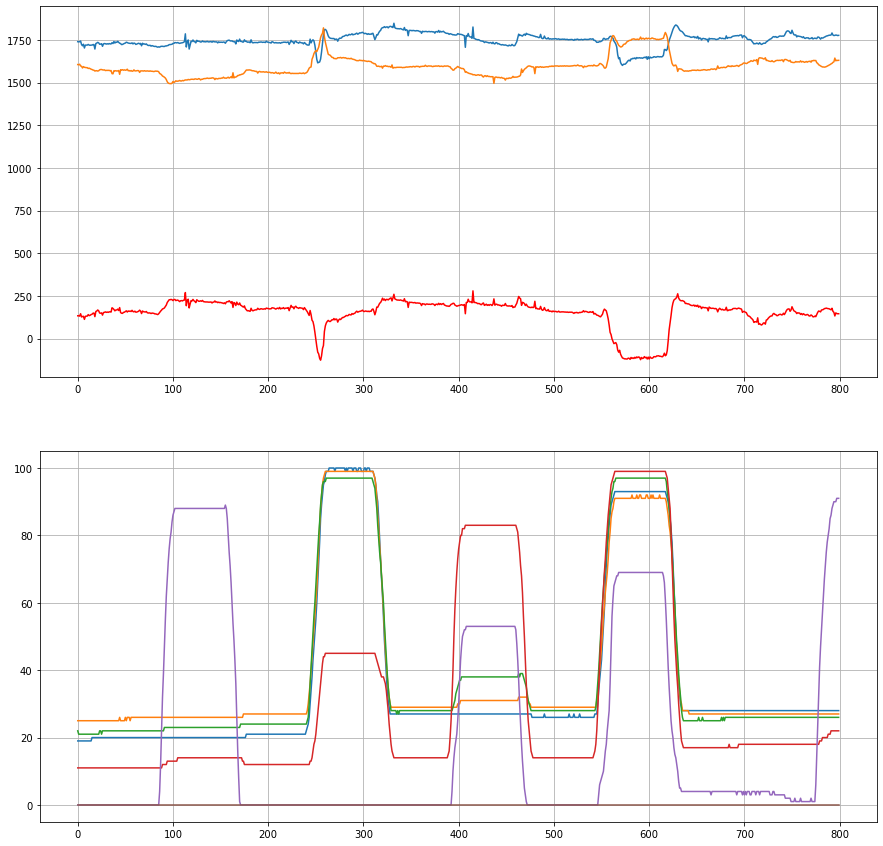

In [275]:
fig, ax = plt.subplots(2,figsize=(15, 15))
ax[0].plot(X_1[:,1][:800])
ax[0].plot(X_1[:,0][:800])
ax[0].plot(X_1[:,1][:800] - X_1[:,0][:800], color = 'red')
ax[1].plot(y[:800])
ax[0].grid()
ax[1].grid()

In [638]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=25):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(gestures_test[OMG_CH + GLOVE_CH])
corr = ['0', '2', '3', '5', '12', '14', '15', '21', '24', '29', '33']

In [8]:
def row_adder(array, n=1):
    new_array = np.zeros((array.shape[0], 151))
    for i in np.arange(array.shape[1]):
        if i == 0:
            new_array[:,i] = array[:,i]
            new_array[:,i+1] = np.rint(np.append(array[:,i][1:], array[:,0].mean()))
            new_array[:,i+2] = np.rint(np.append(array[:,i][2:], [array[:,0].mean(), array[:,0].mean()]))
        else:
            new_array[:,i*3] = array[:,i]
            new_array[:,i*3+1] = np.rint(np.append(array[:,i][1:], array[:,i].mean()))
            new_array[:,i*3+2] = np.rint(np.append(array[:,i][2:], [array[:,i].mean(), array[:,i].mean()]))
    return new_array    


In [72]:
X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
X_new = row_adder(X)
X_test_new = row_adder(X_test)
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

LR = LinearRegression().fit(X, y)
DT = DecisionTreeRegressor(random_state=32).fit(X,y)

In [11]:
y_pred_lr = LR.predict(X)
y_test_pred_lr = LR.predict(X_test)

y_pred_dt = DT.predict(X)
y_test_pred_dt = DT.predict(X_test)

print(pd.DataFrame({'train':MSE(y, y_pred_lr), 'test':MSE(y_test, y_test_pred_lr)}))
print()
print(mse(y_test, y_test_pred_lr))
print()
print(pd.DataFrame({'train':MSE(y, y_pred_dt), 'test':MSE(y_test, y_test_pred_dt)}))
print()
print(mse(y_test, y_test_pred_dt))

        train        test
0   44.761241   57.252958
1   35.262227   37.579762
2   47.073603   48.509950
3  207.066172  263.154448
4  423.469831  546.546481
5    0.000000    0.000000

158.84060002758474

   train        test
0    0.0   67.333497
1    0.0   76.912708
2    0.0   69.425930
3    0.0  374.204089
4    0.0  755.806195
5    0.0    0.000000

223.9470698661443


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

LR = LinearRegression().fit(X_new, y)
DT = DecisionTreeRegressor(random_state=32).fit(X_new,y)

In [13]:
y_pred_lr = np.rint(LR.predict(X_new))
y_test_pred_lr = np.rint(LR.predict(X_test_new))

y_pred_dt = np.rint(DT.predict(X_new))
y_test_pred_dt = np.rint(DT.predict(X_test_new))

print(pd.DataFrame({'train':MSE(y, y_pred_lr), 'test':MSE(y_test, y_test_pred_lr)}))
print()
print(mse(y_test, y_test_pred_lr))
print()
print(pd.DataFrame({'train':MSE(y, y_pred_dt), 'test':MSE(y_test, y_test_pred_dt)}))
print()
print(mse(y_test, y_test_pred_dt))

        train        test
0   38.796636   57.470250
1   28.793048   33.817703
2   37.310141   41.165646
3  178.443115  207.345617
4  368.624623  447.750857
5    0.000000    0.000000

131.25834557623247

   train        test
0    0.0   66.730656
1    0.0   74.366552
2    0.0   73.344760
3    0.0  252.345739
4    0.0  538.613247
5    0.0    0.000000

167.5668258243552


In [34]:
X[:,0].min()

1215

In [33]:
np.quantile(X[:,0], 0)

1215

In [37]:
X[:,0][10101]

1439

In [129]:
def post_1(array):
    new_array = np.zeros_like(array)
    for i in np.arange(array.shape[0]):
        if array[i] <= 10:
            new_array[i] = 0
        elif 10 < array[i] <= 20:
            new_array[i] = 10
        elif 20 < array[i] <= 30:
            new_array[i] = 30
        elif 30 < array[i] <= 40:
            new_array[i] = 40
        elif 40 < array[i] <= 50:
            new_array[i] = 50
        elif 50 < array[i] <= 60:
            new_array[i] = 60
        elif 60 < array[i] <= 70:
            new_array[i] = 70
        elif 70 < array[i] <= 80:
            new_array[i] = 80
        elif 80 < array[i] <= 95:
            new_array[i] = 85
        elif 95 < array[i] <= 100:
            new_array[i] = 90
        else:
            new_array[i] = 100
            
    return new_array
    

In [130]:
def post_2(array):
    new_array = np.copy(array)
    curr_val = array[0]
    for i in np.arange(array.shape[0]):
        if i < 2:
            new_array[i] = array[i]
        else:
            if array[i-2] == array[i]:
                new_array[i-1] = array[i-2]
            else:
                new_array[i] = array[i]
    return new_array

In [131]:
X = gestures_train[OMG_CH].values
X_test = gestures_test[OMG_CH].values
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values

LR = LinearRegression().fit(X, y[:,0])
y_test_pred = np.rint(LR.predict(X_test))

y_1 = post_1(y_test_pred)
y_2 = post_2(y_1)
y_3 = post_1(y_2)

print(f'чистые датчики 1 палец: {mse(y_test[:,0], y_test_pred)}')
print(f'np.rint(): {mse(y_test[:,0], y_test_pred)}')
print(f'post_1: {mse(y_test[:,0], y_1)}')
print(f'post_2: {mse(y_test[:,0], y_2)}')
print(f'post_3: {mse(y_test[:,0], y_3)}')

чистые датчики 1 палец: 57.26922135161606
np.rint(): 57.26922135161606
post_1: 36.54333986287953
post_2: 36.17727717923604
post_3: 39.332272282076396


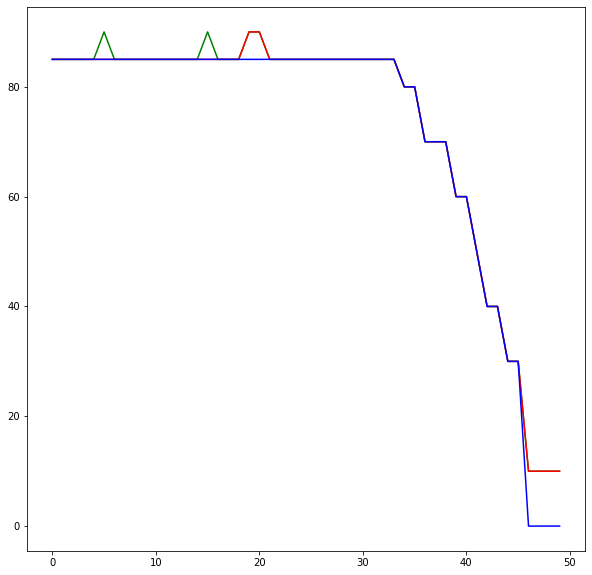

In [132]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(y_1[200:250], color='green')
ax.plot(y_2[200:250], color='red')
ax.plot(y_3[200:250], color='blue')

Text(0.5, 1.0, 'OMG: 25')

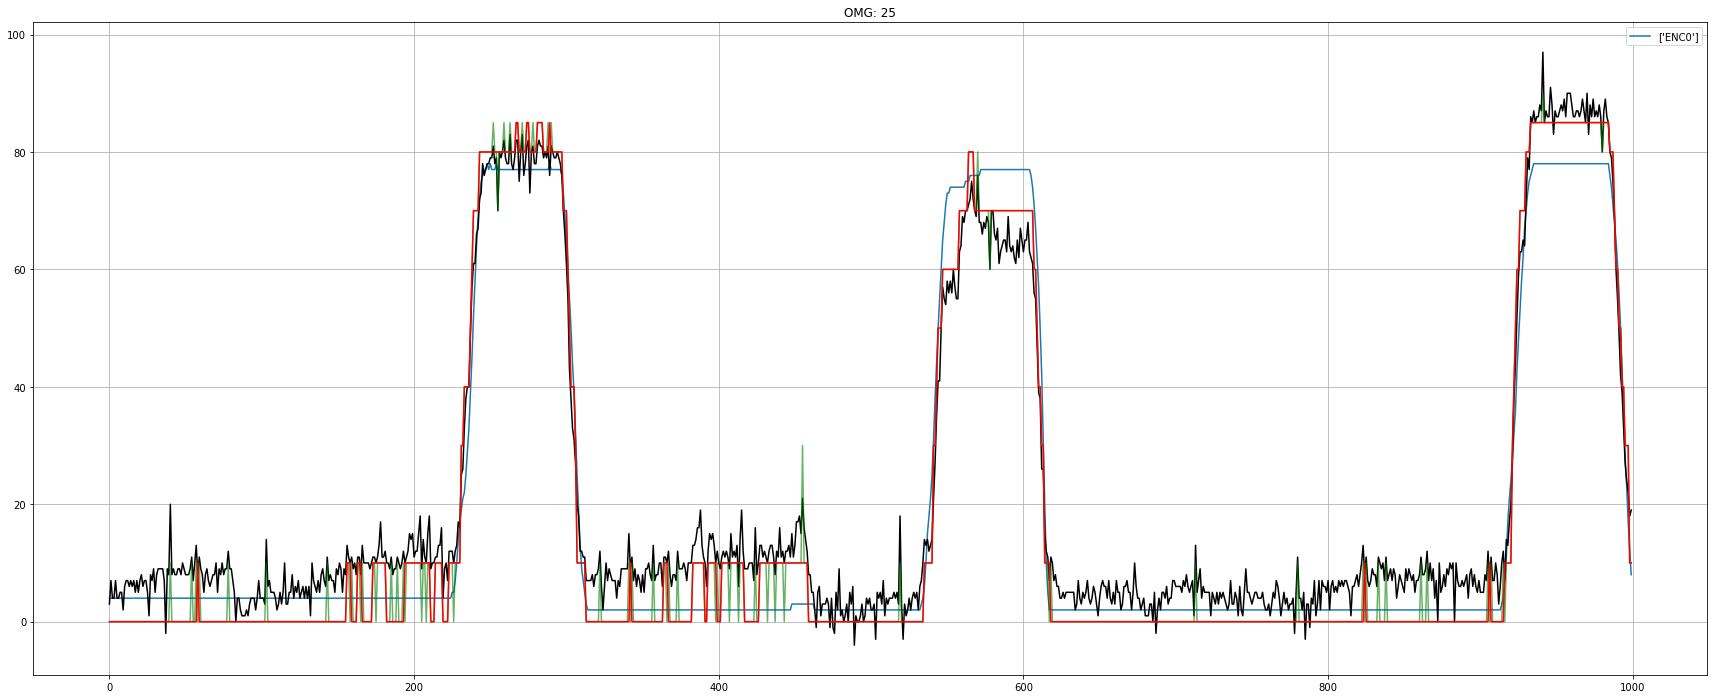

In [133]:
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(y_test[:,[0]][2000:3000], label=GLOVE_CH[:1])
ax.plot(y_test_pred[2000:3000], color='black')
ax.plot(y_1[2000:3000], color='green', alpha=0.6)
ax.plot(y_2[2000:3000], color='red', alpha=1)
ax.grid()
ax.legend()
ax.set_title(f'OMG: {n}')

In [131]:
X_new = quanter(X, 0.001, 0.999)
X_test_new = quanter(X_test, 0.2, 0.9)
y = gestures_train[GLOVE_CH].values
y_test = gestures_test[GLOVE_CH].values


In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

LR = LinearRegression().fit(X_new, y)
DT = DecisionTreeRegressor(random_state=32).fit(X_new,y)

In [209]:
y_pred_lr = LR.predict(X_new)
y_test_pred_lr = LR.predict(X_test_new)

y_pred_dt = DT.predict(X_new)
y_test_pred_dt = DT.predict(X_test_new)

print(pd.DataFrame({'train':MSE(y, y_pred_lr), 'test':MSE(y_test, y_test_pred_lr)}))
print()
print(mse(y_test, y_test_pred_lr))


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed